In [4]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
from sklearn.neighbors import RadiusNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mean_squared_error_sklearn

# Machine Learning and Statistics 2020 Project

The given data set shows pairs of values with headers *speed* and *power*. Under the *speed* heading is the wind speed at the time of measuring and under the *power* heading is the electrical power output for that given wind speed.

By importing and plotting the `powerproduction.csv` a clear shape is evident. Upon research the shape of this plotted data set seems to best be represented with a logistic growth function [https://en.wikipedia.org/wiki/Logistic_function].

![Standard logistic sigmoid function](imgs/Wiki-Logistic-curve.png)

Before plotting the points all rows where the power output is zero will be removed. If there is no power output the machine must be off due to maintance or breakdown.

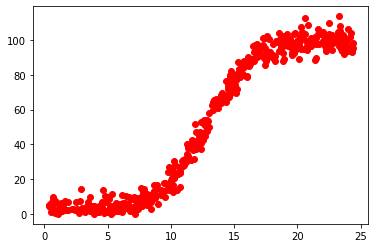

In [5]:
# import csv data and convert to pandas dataframe
df = pd.read_csv("powerproduction.csv")

# remove all zeros
df = df[df.power != 0]

# put rows in order of speed
df = df.sort_values('speed')

# set each column to a numpy array for processing
S = df['speed'].to_numpy()
p = df['power'].to_numpy()

# plot the points
plt.scatter(S, p, c="r")

## Logistic Regression

### Logistic Equation 1

There are many different equations for a logistic function [https://en.wikipedia.org/wiki/Logistic_function]. The first under investigation is the general solution of the general logistic equation, $ \frac{dN}{dt} = rN(1 - \frac{N}{K}) $, where N is the curve's x value, K is curve's maximum x value, and r is the logistic growth rate or steepness of the curve. [https://www.khanacademy.org/math/ap-calculus-bc/bc-differential-equations-new/bc-7-9/v/solving-logistic-differential-equation-part2]. Solving:

$$ \frac{dN}{dt} = rN(1 - \frac{N}{K}) \rightarrow N(t) = \frac{1}{(\frac{1}{N_0} - \frac{1}{K})e^-r(N(t)) + \frac{1}{K}} $$

The function gives a resonable representation of the data with `r = 0.55`. The maximum and minimum values ($ K $ and $ N_0 $ respectively) seem to scew the fit. More investigation will be done below to improve the fit. 

![](imgs/max_P_vals.png)

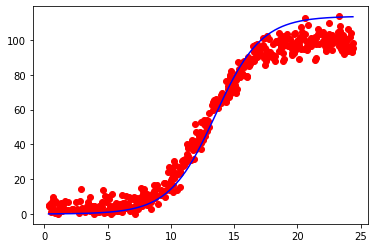

In [6]:
# Set parameters
r= 0.55
K = max(p)
N_0 = min(p)

def log_func_1(S, r, K, N_0):
    # create empty list to contain predicted values of p
    P_s = []

    # Calculate the corresponding p value for each S value and add to list
    for i in range(0, len(S)):
        N_at_speed_s = 1/(((1/N_0 - 1/K)*np.exp(-r*(S[i]))) + 1/K)
        P_s.append(N_at_speed_s)
    
    return P_s

p_predict1 = log_func_1(S, r, K, N_0)
        
# plot function over points
plt.scatter(S, p, c="r")    
plt.plot(S, p_predict1, c="b")

### Logistic Equation 1

Next the much more simple equation for the logistic function is investigated:

$$ f(x) = \frac{L}{1 + e^{-k(x - x_0)}} $$

where:
- $ x_0 $ is the $ x $ value of the sigmoid's midpoint.
- $ L $ is the curve's maximum value.
- $ k $ is the logistic growth rate or steepness of the curve.

below is the function in code form. In it `s` stands for speed ($ x $ in the above equation), `p` stands for power ($ f(x) $ in the above equation), `L` is the maximum value of the curve (same as above calculated as, `max(p)`, greatest value in power), `s_0` is the value of the sigmoid's midpoint ($ x_0 $ in the above equation).

*Note:* k and L are used instead r and K to prevent overlap when running the cells

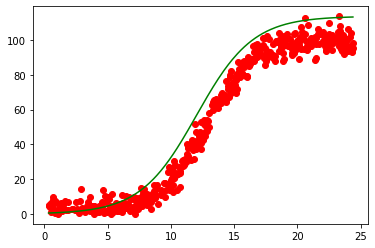

In [7]:
# Set parameters
k = 0.45
L = max(p)
s_0 = (max(S)-min(S))/2

def log_func_2(S, k, L, s_0):
    # create empty list to contain predicted values of p
    P_s = []

    # Calculate the corresponding p value for each S value and add to list
    for i in range(0, len(S)):
        N_at_speed_s = L/(1 + np.exp(-k*(S[i]-s_0)))
        P_s.append(N_at_speed_s)
    return P_s
        
p_predict2 = log_func_2(S, k, L, s_0)

# plot function over points
plt.scatter(S, p, c="r")    
plt.plot(S, p_predict2, c="g")

## Improving accuracy

There are a few things to note for the above investigations. One is that in both the maximum and minimum values scew fit. Also up to this point the value for the logistic growth rate has been guessed and not optimized.

Based on the information given the assumption must be made that all points are valid readings. However in practical terms an argument could be made to remove them as to not predict too high a power output. If you wish to predict power output it is better to under estimate and have excess then to over estimate and have a deficiency. In other words better to be looking at it then looking for it. Anyway, the values for maximum and minimum values actually don't represent the fit accurately. Since there is no reason we can justify removing the higher pouints a different approach is needed. The max and min of the function should be a representation of the mean of a sample of the points at the beginning and end of the data set.

### Max and min values

To deal with the max and min values first an investigation to see what percentage of the points lie where is needed. The following histogram in increments of about 2.5 unit speed (using 10 bins) shows the number of data points in 10% segments. There are 36 values within about the first 10% and 53 in the last 10%. The mean of the first 36 points will be used as a represenation of the minimum value and the last 53 as the maximum value. However an investigation shows that actual minimum value of p works better then the mean of the first 36.

(array([36., 35., 45., 42., 50., 47., 49., 49., 45., 53.]),
 array([ 0.325 ,  2.7324,  5.1398,  7.5472,  9.9546, 12.362 , 14.7694,
        17.1768, 19.5842, 21.9916, 24.399 ]),
 <a list of 10 Patch objects>)

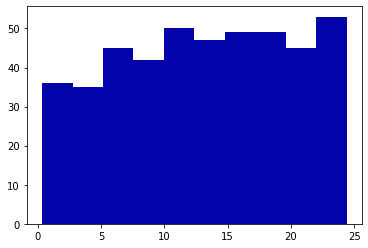

In [8]:
plt.hist(S, bins=10, color='#0504aa',)

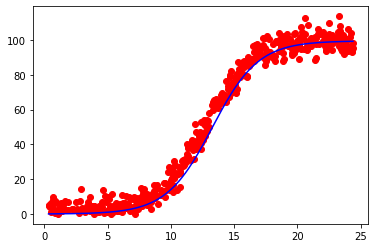

In [9]:
# Using the above method to find the min and max values
K_new = sum(p[-53:])/53
# The method for the min acually makes the fit worse
# N_0_new = sum(p[:36])/36

p_predict3 = log_func_1(S, r, K_new, N_0)

plt.scatter(S, p, c="r")    
plt.plot(S, p_predict3, c="b")

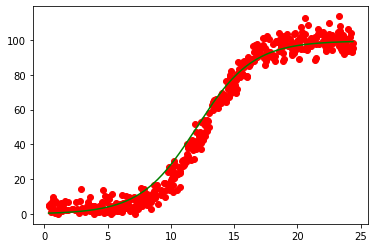

In [10]:
# Using the above method to find the max value
L_new = sum(p[-53:])/53
s_0_new = (max(S)-min(S))/2

p_predict4 = log_func_2(S, k, L_new, s_0_new)

# plot function over points
plt.scatter(S, p, c="r")    
plt.plot(S, p_predict4, c="g")

### r and k values (logistic growth rate or steepness of the curve)


To evaluate the accuracy of the functions the mean squared error (mse) will be calculated. It takes the actual value of power and subtracts the predicted value and squares the difference. It does this for each point and the adds the values and divides by the number of points. [https://www.google.com/search?q=mean+squared+error+formula&rlz=1C1CHBF_enIE917IE917&oq=mean+squared+error&aqs=chrome.2.69i59j0l5j69i60l2.5566j0j7&sourceid=chrome&ie=UTF-8]

$$ MSE = \frac{1}{n} \sum^n_{i=1} (Y_i - \hat{Y}_i )^2 $$

Where $ n $ is number of points to be compated, $ Y_i $ are the actual values and $ \hat{Y}_i $ are the predicted values.

In [11]:
def mean_squared_error(actual, predicted):
    """
    Takes two numpy arrays the actual values and the predicted values to 
    determine the accuracy of the prediction.
    """
    ms = 0
    # loop through and calculate the mse for each point and add it to ms
    for point in range(len(actual)):
        error = (actual[point] - predicted[point])**2
        ms += error
    # calculate the total mse and return
    mse = ms/len(actual)
    return mse

Next to loop through values of r to find the best value for fitting. Using `numpy.arange()` to create an array with increments of 0.005 to test each one

In [ ]:
r_list = np.arange(0, 1, 0.001)

Now we'll tie it all together for both methods. First the solution for general logistic function:

In [ ]:
round(len(S)*0.10)

In [ ]:
sum(p[-53:])/53

In [ ]:
sum(p[-(round(len(S)*0.10)):])/round(len(S)*0.10)

In [12]:
def general_logistic_function(p, S, r, plot = False):
    # 10% of S 
    per = round(len(S)*0.10)
    K = sum(p[-per:])/per
    N_0 = min(p)

    p_predict = log_func_1(S, r, K, N_0)

    if plot == True:
        plt.scatter(S, p, c="r")    
        plt.plot(S, p_predict, c="b")

    else:
        return p_predict, K, N_0
    
def logistic_function(p, S, r, plot = False):
    L = sum(p[-53:])/53
    s_0 = (max(S)-min(S))/2

    p_predict = log_func_2(S, k, L, s_0)

    if plot == True:
        plt.scatter(S, p, c="r")    
        plt.plot(S, p_predict, c="b")
    else:
        return p_predict, L, s_0

In [13]:
def best_r(func, S, p):
    r_list = np.arange(0, 1, 0.001)
    mse_list = []
    r_list_output = []
    for r in r_list:
        mse_list.append(mean_squared_error(p, func(p, S, r)[0]))
        r_list_output.append(r)
    best_r = r_list_output[mse_list.index(min(mse_list))]
    print("Best r value is:", best_r)
    print("MSE value is:", min(mse_list))
    func(p, S, best_r, plot = True)
    return best_r
    

Best r value is: 0.577
MSE value is: 20.309187777809253


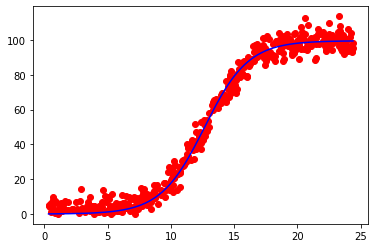

In [14]:
r1 = best_r(general_logistic_function, S, p)

Best r value is: 0.0
MSE value is: 35.22395401423184


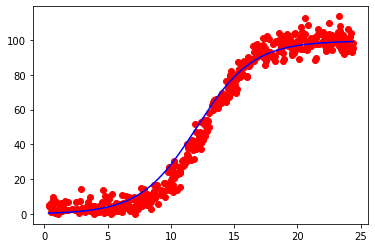

In [15]:
r2 = best_r(logistic_function, S, p)

## sklearn.neighbors: Nearest Neighbors

Next two of scikit learns k-nearest neighbors algorithms, `RadiusNeighborsRegressor` and `KNeighborsRegressor`, will be trained and compared to the above functions.

Because above the max, min,and mid point of the data set were the only values from the data set used there was no need to split the data set. Here however to train and test the models the data set must be split into training and testing sets. This is to avoid the problems of overfitting and underfitting. Overfitting is a situation when a model shows almost perfect accuracy when handling training data. This situation happens when the model has a complex set of rules. When a model is overfitting, it can be inaccurate when handling new data. Underfitting is when a model doesn't fit the training data due to sets of rules that are too simple. You can't rely on an underfitting model to make an accurate prediction. [https://www.bitdegree.org/learn/train-test-split] The common split percentage of 80/20 will be used where the training set is 80% of the original data set and the testing set is 20%. [https://machinelearningmastery.com/train-test-split-for-evaluating-machine-learning-algorithms/]

In [ ]:
# In order to keep the shape right to be processed by sklearn
X = S.reshape(-1, 1)

# Slit the data set to 80/20
X_train, X_test, y_train, y_test = train_test_split(X, p, test_size=0.2
                                                    , random_state=1)

Note that if the `random_state` parameter is left out each time the `train_test_split` is run it will have different values

### RadiusNeighborsRegressor

`RadiusNeighborsRegressor` simply takes the points within a given radius, or "radius neighbors", and calculates an average to predict the power of the input speed [https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsRegressor.html#sklearn.neighbors.RadiusNeighborsRegressor]. 

Below a `radius` of 0.5 is used, later testing will be done to find a more optimal value.

The `weights` attribute set to *distance* will insure that closer neighbors of a query point will have a greater influence than neighbors which are further away.

And with `p` equal to 2 the type of distance for `weights` will be euclidean distances, which is the direct distance from point to point.

Below an instance of the `RadiusNeighborsRegressor` is created and trained on the `X_train` and `y_train` data sets. Then the predicet values of power (`neigh_radius.predict(X_test)`) are compared to the actual values of power (`y_test`) for the wind speeds using the `mean_squared_error` function.

In [ ]:
neigh_radius = RadiusNeighborsRegressor(radius=0.5, weights='distance', p = 2)
neigh_radius.fit(X_train, y_train)
mean_squared_error(y_test, neigh_radius.predict(X_test))

Now we can use our trained model to predict values of power output for a given speed:

In [ ]:
neigh_radius.predict([[1.04]])

To find the optimal value for the `radius` the following values are tested for the mean squared error.

In [ ]:
np.linspace(0.4,2,33)

In [ ]:
for rad in np.linspace(0.4,2,33):
    mses = []
    for i in range(1000):
        X_train, X_test, y_train, y_test = train_test_split(
            X, p, test_size=0.2)
        neigh_radius = RadiusNeighborsRegressor(radius=rad, weights='distance')
        neigh_radius.fit(X_train, y_train)
        xi = neigh_radius.predict(X_test)
        mses.append(mean_squared_error(y_test, neigh_radius.predict(X_test)))
    print("average mse for radius =", round(rad, 3), "is", round((sum(mses)/len(mses)), 3))

From the above test the optimum radius value is 1.7.

In [1]:
rad_o = 1.7

### KNeighborsRegressor

`KNeighborsRegressor` works similar to `RadiusNeighborsRegressor` except that instead of using "neighbors" in a given `radius` it will use the the nearest number of neighbors `n_neighbors`. Below 6 in used for the number of neighbors, later testing will be done to find a more optimal value.

As above an instance of the `KNeighborsRegressor` is created and trained on the `X_train` and `y_train` data sets. Then the predicet values of power (`neigh_k.predict(X_test)`) are compared to the actual values of power (`y_test`) for the wind speeds using the `mean_squared_error` function.

In [ ]:
neigh_k = KNeighborsRegressor(n_neighbors=6)
neigh_k.fit(X_train, y_train)
mean_squared_error(y_test, neigh_k.predict(X_test))

To find the optimal value for the `n_neighbors` the value 2 t0 15 are tested for the mean squared error.

In [ ]:
for n in range(2, 21):
    mses = []
    for i in range(1000):
        X_train, X_test, y_train, y_test = train_test_split(
            X, p, test_size=0.2)
        neigh_k = KNeighborsRegressor(n_neighbors=n)
        neigh_k.fit(X_train, y_train)
        mses.append(mean_squared_error(y_test, neigh_k.predict(X_test)))
    print("average mse for n =", n, "is", round((sum(mses)/len(mses)), 3))

From the above test the optimum number of neighbors is 12.

In [2]:
n_o = 19

## Results:

In order to keep things "fair" a final test on all models using optimal values on the same subset of the orignal data set.

In [35]:
# In order to keep the shape right to be processed by sklearn
X = S.reshape(-1, 1)

# Slit the data set to 80/20
X_train, X_test, y_train, y_test = train_test_split(X, p, test_size=0.2
                                                    , random_state=3)

In [36]:
p, K, N_0 = general_logistic_function(p, S, r1)

y_pred_1 = log_func_1(X_test, r1, K, N_0)
mean_squared_error(y_test, y_pred_1)

array([259.96076223])

In [37]:
p, L, s_0 = logistic_function(p, S, r2)

y_pred_2 = log_func_2(X_test, r, L, s_0)
mean_squared_error(y_test, y_pred_2)

array([6.37318334])

In [38]:
neigh_radius_test = RadiusNeighborsRegressor(radius=rad_o, weights='distance', p = 2)
neigh_radius_test.fit(X_train, y_train)
y_pred_3 = neigh_radius_test.predict(X_test)
mean_squared_error(y_test, y_pred_3)

0.1558403142892807

In [39]:
neigh_k_test = KNeighborsRegressor(n_neighbors=n_o)
neigh_k_test.fit(X_train, y_train)
y_pred_4 = neigh_k_test.predict(X_test)
mean_squared_error(y_test, y_pred_4)


0.21430566078437374

And the winner is radius. With:
radius = 1.7
weights='distance'